## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [53]:
import torch
print(torch.__version__)  # 檢查 PyTorch 版本
print(torch.cuda.is_available())  # 檢查 CUDA 是否可用


2.5.1
True


In [54]:
import torch
torch.cuda.is_available()

True

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [55]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: C:\Users\Wu Lab\Desktop\sam2


### Imports

In [56]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [57]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [58]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)
sam2_model.load_state_dict(torch.load("model.torch")) #新訓練的模型

<All keys matched successfully>

## Preprocess video

### 要測試的影片

In [59]:
SOURCE_VIDEO = 'C:/Users/Wu Lab/Desktop/sam2/nccdtest2.avi'
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=3840, height=2160, fps=29, total_frames=387)

**NOTE:** To reduce VRAM requirements, we are introducing three additional parameters: `SCALE_FACTOR` to decrease the frame resolution, and `START_IDX` and `END_IDX` to extract only the relevant segments from the video.

In [60]:
SCALE_FACTOR = 0.5
START_IDX = 0
END_IDX = 360# 切幾張影像

In [61]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)
 #影片切照片
with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [62]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 360/360 [00:13<00:00, 26.49it/s]


In [63]:
# 輕緩存
import torch
torch.cuda.empty_cache()

### 重新選擇座標

In [64]:
sam2_model.reset_state(inference_state)

### Prompting with points

In [65]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

### 設定要追蹤幾個粒子

In [66]:
OBJECTS = ['target', 'target_2','target_3','target_4','target_5']

### 選要追蹤的粒子

In [68]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

# FRAME_PATH = './odep/00000.jpeg'
widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['target', 'target_2', 'target_3', 'target_4', 'target_5'], colors=['#1f77b4', '#ff7f0e', '…

**NOTE:** The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

In [69]:
default_box = [
    [{'x': 712, 'y': 797, 'width': 0, 'height': 1, 'label': 'target'}]
]

boxes = widget.bboxes if widget.bboxes else default_box
print(boxes)
for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

[{'x': 1224, 'y': 125, 'width': 0, 'height': 0, 'label': 'target'}, {'x': 1466, 'y': 577, 'width': 0, 'height': 0, 'label': 'target_2'}, {'x': 1697, 'y': 802, 'width': 0, 'height': 0, 'label': 'target_3'}, {'x': 1748, 'y': 981, 'width': 0, 'height': 0, 'label': 'target_4'}, {'x': 402, 'y': 1030, 'width': 0, 'height': 0, 'label': 'target_5'}]



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


### 選座標

### 固定座標

### Video inference

**NOTE:** To apply our point prompts to all video frames, we use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which we can convert to masks using thresholding.

### 偵測 2 個以上的 classes

propagate in video:   0%|          | 0/360 [00:00<?, ?it/s]

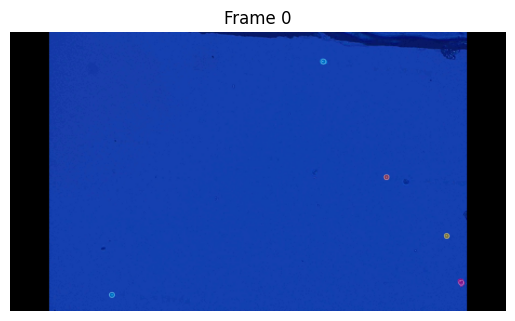

propagate in video:   0%|          | 1/360 [00:00<02:20,  2.56it/s]UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:773.)
Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).
propagate in video: 100%|██████████| 360/360 [31:06<00:00,  5.19s/it]


In [70]:
import matplotlib.pyplot as plt
import cv2
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        # Convert masks to bounding boxes (xyxy format)
        xyxy_boxes = sv.mask_to_xyxy(masks=masks)

        # Create detections with bounding boxes, masks, and class IDs
        detections = sv.Detections(
            xyxy=xyxy_boxes,
            mask=masks,
            class_id=np.array(object_ids)
        )

        # Annotate the frame with detected masks
        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        # Draw circles around detected objects in the desired style
        for box in xyxy_boxes:
            center_x = int((box[0] + box[2]) / 2)
            center_y = int((box[1] + box[3]) / 2)
            radius = 10  # Small radius for circle similar to matplotlib's style
            color = (255, 255, 255)  # White color in BGR format
            thickness = 1  # Adjust thickness to create a ring-like appearance

            # Draw the circle with no fill, imitating the matplotlib circle style
            cv2.circle(annotated_frame, (center_x, center_y), radius, color, thickness)

        # Display the first frame's result if needed
        if frame_idx == 0:
            plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
            plt.title('Frame 0')
            plt.axis('off')
            plt.show()

        # Write the annotated frame to the video sink
        sink.write_frame(annotated_frame)

        # Save sampled frames at the video's FPS interval
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)


### 同時生成影片和預測 mask

propagate in video:   0%|          | 0/360 [00:00<?, ?it/s]

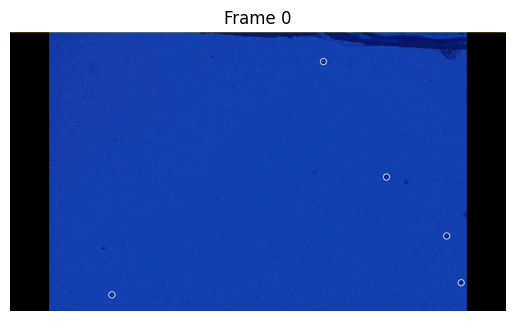

propagate in video: 100%|██████████| 360/360 [10:02:51<00:00, 100.48s/it] 


In [71]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

masks = (mask_logits > 0.0).to('cuda')  # 在 GPU 上计算
masks = masks.squeeze().cpu().numpy()  # 返回到 CPU 继续后续操作
# 确保 pred_mask 文件夹存在
pred_mask_folder = 'C:/Users/Wu Lab/Desktop/sam2/predict_result/predict_masks/nccdtest2_60imgmodel' # 預測 mask 影像資料夾路徑
os.makedirs(pred_mask_folder, exist_ok=True)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(np.uint8)  # 将 mask 转换为 uint8 格式
        
        # Convert masks to bounding boxes (xyxy format)
        xyxy_boxes = sv.mask_to_xyxy(masks=masks)

        # Create detections with bounding boxes, masks, and class IDs
        detections = sv.Detections(
            xyxy=xyxy_boxes,
            mask=masks,
            class_id=np.array(object_ids)
        )

        # Annotate the frame with detected masks
        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        # Draw circles around detected objects in the desired style
        for box in xyxy_boxes:
            center_x = int((box[0] + box[2]) / 2)
            center_y = int((box[1] + box[3]) / 2)
            radius = 12  # Small radius for circle similar to matplotlib's style
            color = (255, 255, 255)  # White color in BGR format
            thickness = 2  # Adjust thickness to create a ring-like appearance

            # Draw the circle with no fill, imitating the matplotlib circle style
            cv2.circle(annotated_frame, (center_x, center_y), radius, color, thickness)

        # Display the first frame's result if needed
        if frame_idx == 0:
            plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
            plt.title('Frame 0')
            plt.axis('off')
            plt.show()

        # Write the annotated frame to the video sink
        sink.write_frame(annotated_frame)

        # Save sampled frames at the video's FPS interval
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

        # Save the predicted mask as a black-and-white image to the pred_mask folder
        mask_image_path = os.path.join(pred_mask_folder, f'{frame_idx:05d}.png')
        
        # 将 mask 值转换为黑白（0 和 255）
        mask_bw = (masks * 255).astype('uint8')  # Convert mask to black (0) and white (255)

        # 如果是多通道 mask，将其合并为单一通道
        if mask_bw.ndim == 3:
            mask_bw = mask_bw.max(axis=0)  # 选取最大值来处理多通道

        # Debug information
#         print(f"Saving mask for frame {frame_idx} to {mask_image_path}")
        success = cv2.imwrite(mask_image_path, mask_bw)
        if not success:
            print(f"Failed to save mask for frame {frame_idx}")

### 計算 IoU

In [38]:
# import numpy as np
# import cv2
# import os
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# import pandas as pd
# import natsort


# # save data to excel
# dic = {"filename1": [],"filename2": [], "A": []}

# path1 = 'C:/Users/User/Desktop/sam2/predict_result/results_answer/323-1masks' # labeling directory path
# path2 = 'C:/Users/User/Desktop/sam2/predict_result/predict_masks/323-1 newmodel'  # predict directory path
# dirs = os.listdir(path1)
# dirs = natsort.natsorted(dirs)
# #print(dirs)
# dirs2 = os.listdir(path2)
# dirs2 = natsort.natsorted(dirs2)




# for num in range(0, len(dirs)):
#     labeling_path = os.path.join(path1, dirs[num])
#     predict_path = os.path.join(path2, dirs2[num])
#     labeling = cv2.imread(labeling_path)
#     predict = cv2.imread(predict_path)
    
#     y_true = list(labeling.ravel())
#     y_pred = list(predict.ravel())
#     converted = set(y_true)
#     converted2 = set(y_pred)
#     matrix = confusion_matrix(y_true, y_pred, labels=[0, 255])

#     labels = ['_bg', 'A']
    
#     dic["filename1"].append(dirs[num])
#     dic["filename2"].append(dirs2[num])
#     for i in range(0, 2):
#         tp = matrix[i][i]
#         fp = 0
#         fn = 0
#         for j in range(0, 2):
#             if i == j: pass
#             else:
#                 fp += matrix[i][j]
#                 fn += matrix[j][i]
#         if i != 0:
#             if (tp + fp + fn) == 0:
#                 dic[labels[i]].append("NaN")
#             else:
#                 iou = tp / (tp + fp + fn)
#                 dic[labels[i]].append(str(iou.round(4)))
#     #print(dic)

# # save data to excel
# data = pd.DataFrame(dic)
# print(data)
# data.to_excel("C:/Users/User/Desktop/sam2/IoU/323-1 newmodel.xlsx",index = False)
# print("已儲存")

    filename1  filename2       A
0   00000.png  00000.png  0.1525
1   00001.png  00001.png    0.16
2   00002.png  00002.png  0.1579
3   00003.png  00003.png  0.1957
4   00004.png  00004.png    0.18
5   00005.png  00005.png  0.1957
6   00006.png  00006.png  0.1957
7   00007.png  00007.png  0.2093
8   00008.png  00008.png  0.2143
9   00009.png  00009.png  0.1429
10  00010.png  00010.png  0.2174
11  00011.png  00011.png  0.1333
12  00012.png  00012.png  0.2381
13  00013.png  00013.png    0.25
14  00014.png  00014.png    0.25
15  00015.png  00015.png  0.1304
16  00016.png  00016.png  0.2222
17  00017.png  00017.png  0.2381
18  00018.png  00018.png  0.1429
19  00019.png  00019.png  0.2439
20  00020.png  00020.png  0.1463
21  00021.png  00021.png    0.15
22  00022.png  00022.png  0.2439
23  00023.png  00023.png    0.25
24  00024.png  00024.png  0.2381
25  00025.png  00025.png    0.25
26  00026.png  00026.png  0.2195
27  00027.png  00027.png  0.0976
28  00028.png  00028.png  0.1951
29  00029.

## 準確率計算
<style>
    color = blue
</style>

In [74]:
import numpy as np
import cv2
import os
import pandas as pd

def calculate_centroid(mask):
    y, x = np.nonzero(mask)
    centroid = (np.mean(x), np.mean(y))
    return centroid

def is_within_radius(predicted_centroid, true_centroid, radius):
    distance = np.sqrt((predicted_centroid[0] - true_centroid[0]) ** 2 + 
                       (predicted_centroid[1] - true_centroid[1]) ** 2)
    return distance <= radius

# 資料夾路徑
true_mask_folder = "C:/Users/Wu Lab/Desktop/sam2/predict_result/results_answer/nccdtest1masks"
predicted_mask_folder = "C:/Users/Wu Lab/Desktop/sam2/predict_result/predict_masks/nccdtest2"
radius = 24.75  # 設定圓的半徑

# 建立一個列表來儲存結果
results = []

# 遍歷正解資料夾中的每一個 mask
for filename in os.listdir(true_mask_folder):
    if filename.endswith(".png"):  # 假設 mask 是 png 格式
        true_mask_path = os.path.join(true_mask_folder, filename)
        predicted_mask_path = os.path.join(predicted_mask_folder, filename)

        true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
        predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

        if true_mask is None or predicted_mask is None:
            print(f"Error reading mask for {filename}")
            continue

        # 計算重心
        true_centroid = calculate_centroid(true_mask)
        predicted_centroid = calculate_centroid(predicted_mask)

        # 判斷預測重心是否在正解重心的範圍內
        in_radius = is_within_radius(predicted_centroid, true_centroid, radius)
        
        # 將結果加入到列表中
        results.append({
            "predict": filename,
            "answer": filename,
            "result": "Correct" if in_radius else "Incorrect"
        })
print(results)
# 創建 DataFrame
df = pd.DataFrame(results)

# 計算正確率
accuracy = df['result'].value_counts().get("Correct", 0) / len(df)

# 將正確率新增為一行
accuracy_row = pd.DataFrame([{"predict": "", "answer": "accuracy", "result": accuracy}])
df = pd.concat([df, accuracy_row], ignore_index=True)

# 將 DataFrame 寫入 Excel
output_path = "nccdtest2.xlsx"
df.to_excel(output_path, index=False)

print(f"Results saved to {output_path}")


[{'predict': '00000.png', 'answer': '00000.png', 'result': 'Correct'}, {'predict': '00001.png', 'answer': '00001.png', 'result': 'Incorrect'}, {'predict': '00002.png', 'answer': '00002.png', 'result': 'Correct'}, {'predict': '00003.png', 'answer': '00003.png', 'result': 'Incorrect'}, {'predict': '00004.png', 'answer': '00004.png', 'result': 'Incorrect'}, {'predict': '00005.png', 'answer': '00005.png', 'result': 'Incorrect'}, {'predict': '00006.png', 'answer': '00006.png', 'result': 'Incorrect'}, {'predict': '00007.png', 'answer': '00007.png', 'result': 'Incorrect'}, {'predict': '00008.png', 'answer': '00008.png', 'result': 'Incorrect'}, {'predict': '00009.png', 'answer': '00009.png', 'result': 'Incorrect'}, {'predict': '00010.png', 'answer': '00010.png', 'result': 'Incorrect'}, {'predict': '00011.png', 'answer': '00011.png', 'result': 'Correct'}, {'predict': '00012.png', 'answer': '00012.png', 'result': 'Incorrect'}, {'predict': '00013.png', 'answer': '00013.png', 'result': 'Incorrect'

In [75]:
print(accuracy)

0.18
